# Activate GPU if available

In [1]:
import torch

# Check for GPU availability
if torch.cuda.is_available():
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using the CPU instead.")

# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Using GPU: NVIDIA GeForce RTX 3080


# Setting up the dataset 
It downloads and sets up a directory 'data' the first time this cell is executed

Total number of training images: 60000
Total number of testing images: 10000
Total number of training images in subset: 60000
Total number of testing images in subset: 10000
Training data range: min = 0.0, max = 1.0
Testing data range: min = 0.0, max = 1.0
Loaded batch size: 64
Images shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])


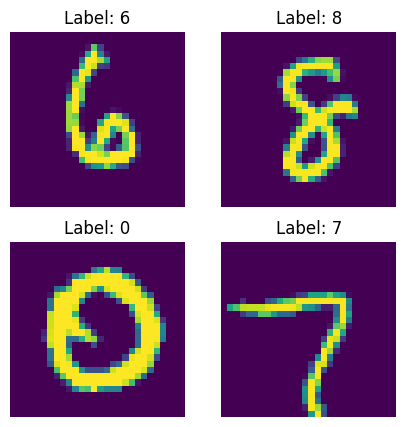

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

# Define transformations for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load MNIST dataset with the new transform
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Print total number of items in the datasets
print(f"Total number of training images: {len(train_dataset)}")
print(f"Total number of testing images: {len(test_dataset)}")

# Subset the datasets to include only a set number of examples
num_samples_train = 60000  # Number of samples to include in the training subset
num_samples_test = 10000    # Number of samples to include in the testing subset

indices_train = np.random.choice(len(train_dataset), num_samples_train, replace=False)
indices_test = np.random.choice(len(test_dataset), num_samples_test, replace=False)

subset_train_dataset = Subset(train_dataset, indices_train)
subset_test_dataset = Subset(test_dataset, indices_test)

# Print number of selected items in the subsets
print(f"Total number of training images in subset: {len(subset_train_dataset)}")
print(f"Total number of testing images in subset: {len(subset_test_dataset)}")

# Create data loaders with subsets
train_loader = DataLoader(subset_train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(subset_test_dataset, batch_size=64, shuffle=False)

# Function to check the range of pixel values in the dataset
def check_image_range(loader):
    min_val, max_val = float('inf'), float('-inf')
    for images, _ in loader:
        batch_min, batch_max = images.min().item(), images.max().item()
        min_val, max_val = min(min_val, batch_min), max(max_val, batch_max)
        # Break after the first batch if only a quick check is needed
        break
    return min_val, max_val

train_min, train_max = check_image_range(train_loader)
test_min, test_max = check_image_range(test_loader)

print(f"Training data range: min = {train_min}, max = {train_max}")
print(f"Testing data range: min = {test_min}, max = {test_max}")

# Example of accessing and plotting the first batch of images
for images, labels in train_loader:
    print(f"Loaded batch size: {images.shape[0]}")
    print(f"Images shape: {images.shape}")  # Shape of images in a batch
    print(f"Labels shape: {labels.shape}")  # Shape of labels in a batch

    # Displaying a few example images from the batch
    plt.figure(figsize=(5, 5))
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].squeeze(), cmap='viridis')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break  # Only process the first batch


# Initialize the model

tested with latent_dim_size = 4, 6, 8, 10, 15, 20, 32

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

class EnhancedVAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(EnhancedVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            self._conv_bn_relu(1, 32, 4, 2, 1),  # 28x28 -> 14x14
            self._conv_bn_relu(32, 64, 4, 2, 1),  # 14x14 -> 7x7
            self._conv_bn_relu(64, 128, 3, 2, 1),  # 7x7 -> 4x4
            self._conv_bn_relu(128, 256, 4, 1, 0)  # 4x4 -> 1x1
        )
        self.fc1 = nn.Linear(256, 512)
        self.fc21 = nn.Linear(512, latent_dim)  # Mean of latent variable
        self.fc22 = nn.Linear(512, latent_dim)  # Log variance of latent variable
        
        # Decoder
        self.fc3 = nn.Linear(latent_dim, 512)
        self.fc4 = nn.Linear(512, 256)
        self.decoder = nn.Sequential(
            self._conv_transpose_bn_relu(256, 128, 4, 1, 0),  # 1x1 -> 4x4
            self._conv_transpose_bn_relu(128, 64, 3, 2, 1),  # 4x4 -> 7x7
            self._conv_transpose_bn_relu(64, 32, 4, 2, 1),  # 7x7 -> 14x14
            nn.ConvTranspose2d(32, 1, 4, 2, 1),  # 14x14 -> 28x28
            nn.Sigmoid()
        )
        
        self._init_weights()

    def _conv_bn_relu(self, in_channels, out_channels, *args, **kwargs):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, *args, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def _conv_transpose_bn_relu(self, in_channels, out_channels, *args, **kwargs):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, *args, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        h = F.leaky_relu(self.fc1(h), 0.2)
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.leaky_relu(self.fc3(z), 0.2)
        h = F.leaky_relu(self.fc4(h), 0.2)
        h = h.view(-1, 256, 1, 1)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar, kld_weight=1.0):
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + kld_weight * KLD

# Define latent dimension size
latent_dim_size = 10

# Initialize model and optimizer with the chosen latent dimension size

model = EnhancedVAE(latent_dim=latent_dim_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop

In [5]:
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Training loop
def train(model, optimizer, data_loader, epochs, device, log_interval=10, kld_weight=1.0):
    model.train()
    train_losses = []
    total_batches = len(data_loader) * epochs
    
    with tqdm(total=total_batches, desc='Training', unit='batch') as pbar:
        for epoch in range(1, epochs + 1):
            total_loss = 0
            for batch_idx, (data, _) in enumerate(data_loader):
                data = data.to(device)
                optimizer.zero_grad()
                recon_batch, mu, logvar = model(data)
                loss = loss_function(recon_batch, data, mu, logvar, kld_weight)
                loss.backward()
                total_loss += loss.item()
                optimizer.step()
                
                if (batch_idx + 1) % log_interval == 0:
                    pbar.set_postfix({'loss': loss.item() / len(data)})
                pbar.update(1)
            
            average_loss = total_loss / len(data_loader.dataset)
            train_losses.append(average_loss)
            pbar.set_description(f'Epoch {epoch}/{epochs}')
            # print(f'Epoch {epoch}, Average loss: {average_loss:.4f}')
    
    return train_losses

# Training the model
epochs = 100
log_interval = 50
kld_weight = 1

# Assuming model, optimizer, train_loader, and device are already defined
train_losses = train(model, optimizer, train_loader, epochs, device, log_interval, kld_weight)


Training:   0%|          | 0/93800 [00:00<?, ?batch/s]

# Plot the losses

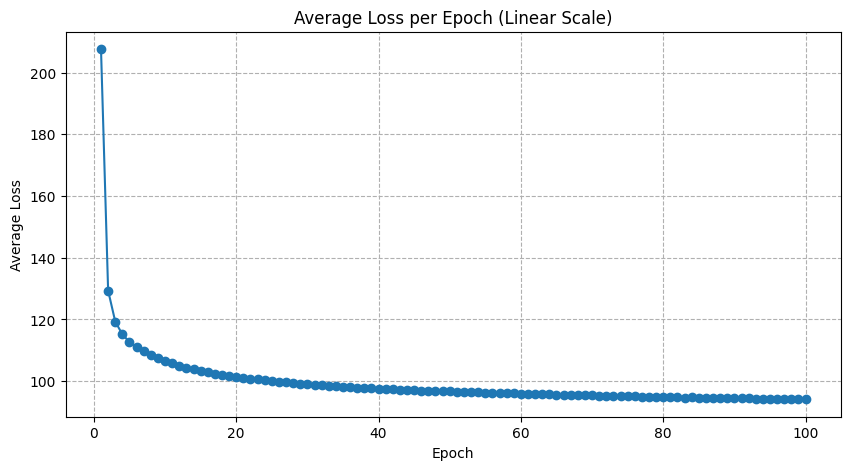

In [6]:
import matplotlib.pyplot as plt

# Function to plot the losses with a selectable y-axis scale
def plot_losses(losses, scale='log'):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(losses) + 1), losses, marker='o')
    plt.title(f'Average Loss per Epoch ({scale.capitalize()} Scale)')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.yscale(scale)
    plt.grid(True, which="both", ls="--")
    plt.show()

# Example usage
plot_losses(train_losses, scale='linear')  # Change 'log' to 'linear' for linear scale


# Display original and reconstructed images with labels

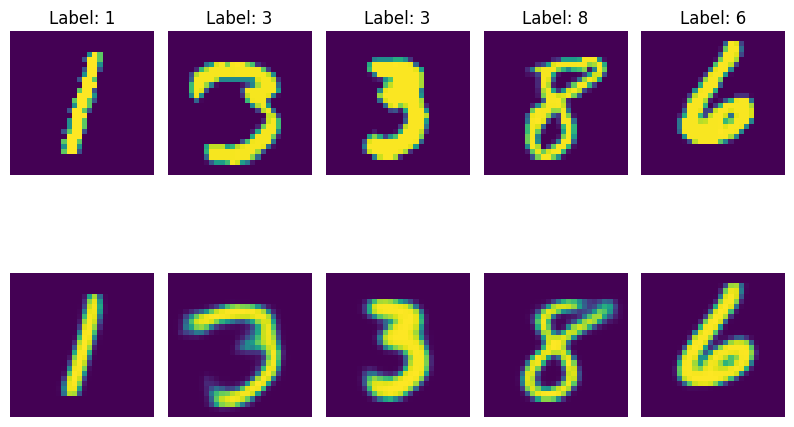

In [15]:
import random
import torch
import matplotlib.pyplot as plt

# Function to visualize results
def visualize_results(model, data_loader, num_images=10):
    model.eval()
    with torch.no_grad():
        for data, labels in data_loader:
            data = data.to(device)
            recon, _, _ = model(data)
            break

    # Randomly select num_images indices
    indices = random.sample(range(len(data)), num_images)

    # Display original and reconstructed images with labels
    plt.figure(figsize=(2 * num_images, 6))
    for i, idx in enumerate(indices):
        # Original
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(data[idx].cpu().numpy().reshape(28, 28), cmap='viridis')
        plt.title(f'Label: {labels[idx].item()}')
        plt.xlabel('Original')
        plt.axis('off')

        # Reconstructed
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(recon[idx].cpu().numpy().reshape(28, 28), cmap='viridis')
        plt.xlabel('Reconstructed')
        plt.axis('off')

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

# Example usage with variable number of images
num_images_to_display = 5
visualize_results(model, test_loader, num_images=num_images_to_display)


# Generate and visualize random numbers from a standard normal distribution

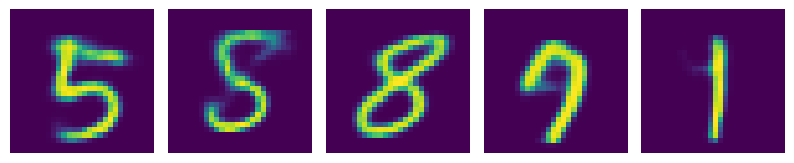

In [7]:
import torch
import matplotlib.pyplot as plt

# Function to generate and visualize random numbers
def generate_random_numbers(model, num_samples=10, latent_dim_size=latent_dim_size):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim_size).to(device)  # Sample from a standard normal distribution
        samples = model.decode(z).cpu()

    plt.figure(figsize=(2 * num_samples, 16))
    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(samples[i].numpy().reshape(28, 28), cmap='viridis')
        plt.axis('off')
    
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.show()

# Generate and visualize random numbers
generate_random_numbers(model, num_samples=5)


# Extract latent space activations with testing subset

In [8]:
import numpy as np
import pandas as pd
import torch
from tqdm.notebook import tqdm

def extract_latent_activations(model, data_loader, device):
    model.eval()
    activations = []
    with torch.no_grad():
        for data, labels in tqdm(data_loader, desc="Extracting latent activations"):
            data = data.to(device)
            mu, logvar = model.encode(data)
            latent_space = model.reparameterize(mu, logvar)
            
            for i in range(len(labels)):
                digit = labels[i].item()
                latent_rep = latent_space[i].cpu().numpy()
                
                # Add overall latent representation
                activation_dict = {
                    'Digit': digit,
                    'Latent Representation': latent_rep
                }
                
                # Add individual neuron activations
                for j, activation in enumerate(latent_rep):
                    activation_dict[f'Latent Neuron {j}'] = j
                    activation_dict[f'Activation {j}'] = activation
                
                activations.append(activation_dict)
    
    return pd.DataFrame(activations)

# Assuming test_loader is your DataLoader and model is your VAE model
df = extract_latent_activations(model, test_loader, device)

Extracting latent activations:   0%|          | 0/157 [00:00<?, ?it/s]

# Visualize the neuron activations for each digit as a heatmap and print out the prototype values

Digit prototypes are generated from a testing subset and can be used for iterating over the neuron values of a specific digit.

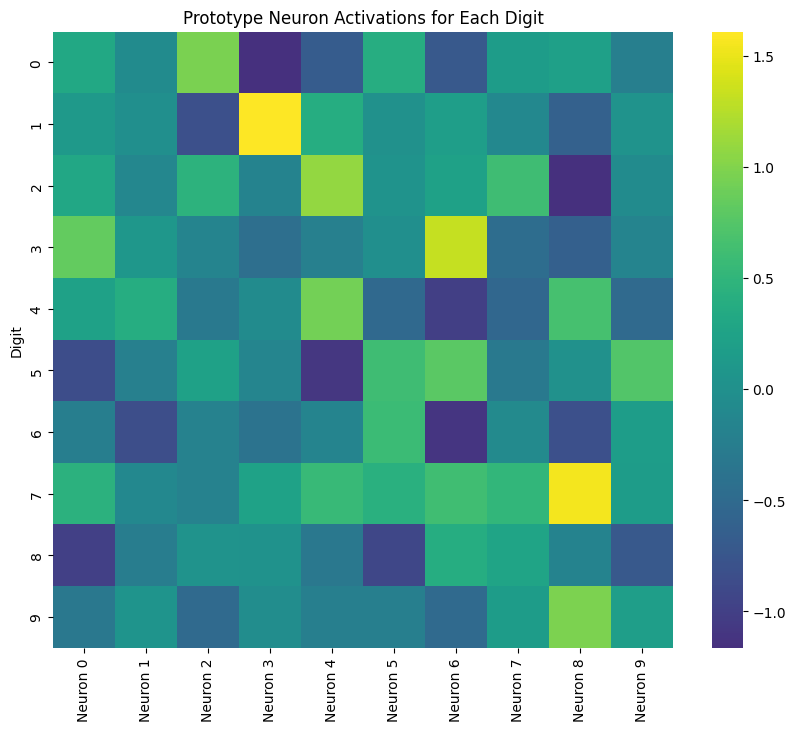

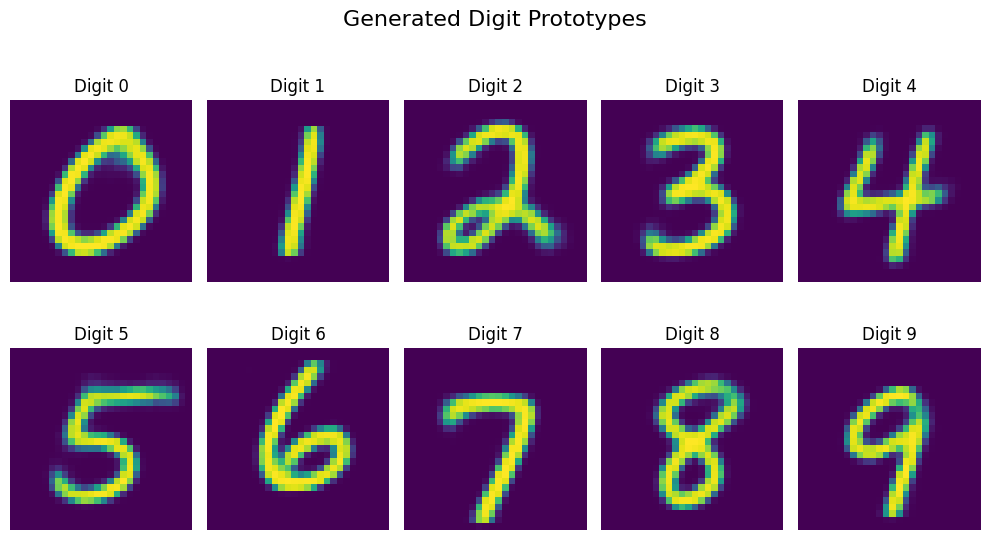

Digit 0:
neuron_values = {
    0: 0.310536,
    1: -0.059357,
    2: 0.962403,
    3: -1.162724,
    4: -0.679182,
    5: 0.390523,
    6: -0.714801,
    7: 0.150482,
    8: 0.204241,
    9: -0.240711,
}

Digit 1:
neuron_values = {
    0: 0.117287,
    1: -0.023987,
    2: -0.820895,
    3: 1.609808,
    4: 0.385813,
    5: 0.000786,
    6: 0.187057,
    7: -0.102743,
    8: -0.611767,
    9: 0.043508,
}

Digit 2:
neuron_values = {
    0: 0.305835,
    1: -0.113732,
    2: 0.455601,
    3: -0.169453,
    4: 1.087680,
    5: 0.040137,
    6: 0.232120,
    7: 0.607338,
    8: -1.159664,
    9: -0.065628,
}

Digit 3:
neuron_values = {
    0: 0.835162,
    1: 0.096755,
    2: -0.148841,
    3: -0.447652,
    4: -0.215509,
    5: -0.015693,
    6: 1.324132,
    7: -0.472459,
    8: -0.630288,
    9: -0.160928,
}

Digit 4:
neuron_values = {
    0: 0.227010,
    1: 0.382918,
    2: -0.303160,
    3: -0.059796,
    4: 0.919110,
    5: -0.515655,
    6: -1.000581,
    7: -0.540078,
    8: 0.665

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
import numpy as np

def calculate_digit_prototypes(df):
    # Extract the activation columns
    activation_columns = [col for col in df.columns if col.startswith('Activation')]
    
    # Compute average activations per neuron per digit
    prototypes = df.groupby('Digit')[activation_columns].mean()
    
    # Rename columns to match the original format
    prototypes.columns = [f'Neuron {i}' for i in range(len(activation_columns))]
    
    return prototypes

def generate_prototype_images(model, prototypes, device):
    model.eval()
    with torch.no_grad():
        # Convert prototypes to tensor
        prototype_tensors = torch.tensor(prototypes.values, dtype=torch.float32).to(device)
        
        # Generate images
        generated_images = model.decode(prototype_tensors).cpu().numpy()
        
        # Plot the generated images
        fig, axes = plt.subplots(2, 5, figsize=(10, 6))
        for i, ax in enumerate(axes.flat):
            ax.imshow(generated_images[i].reshape(28, 28), cmap='viridis')
            ax.set_title(f"Digit {i}")
            ax.axis('off')
        
        plt.suptitle("Generated Digit Prototypes", fontsize=16)
        plt.tight_layout()
        plt.show()

# Calculate prototypes
prototypes = calculate_digit_prototypes(df)

# Display the prototypes as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(prototypes, cmap='viridis', center=0, annot=False, fmt='.2f')
plt.title('Prototype Neuron Activations for Each Digit')
# plt.xlabel('Latent Neuron')
plt.ylabel('Digit')
plt.show()

# Generate and display prototype images
generate_prototype_images(model, prototypes, device)

# Print the prototype values for each digit in the specified format
for digit in range(10):
    print(f"Digit {digit}:")
    print(f"neuron_values = {{")
    for neuron_index, (neuron, value) in enumerate(prototypes.loc[digit].items()):
        print(f"    {neuron_index}: {value:.6f},")
    print("}\n")

# Iterate over selected neurons within a set value range

This visualization aims to help in understanding the feature mappings within selected neurons. By using digit prototype values, we can explore digit-specific features.

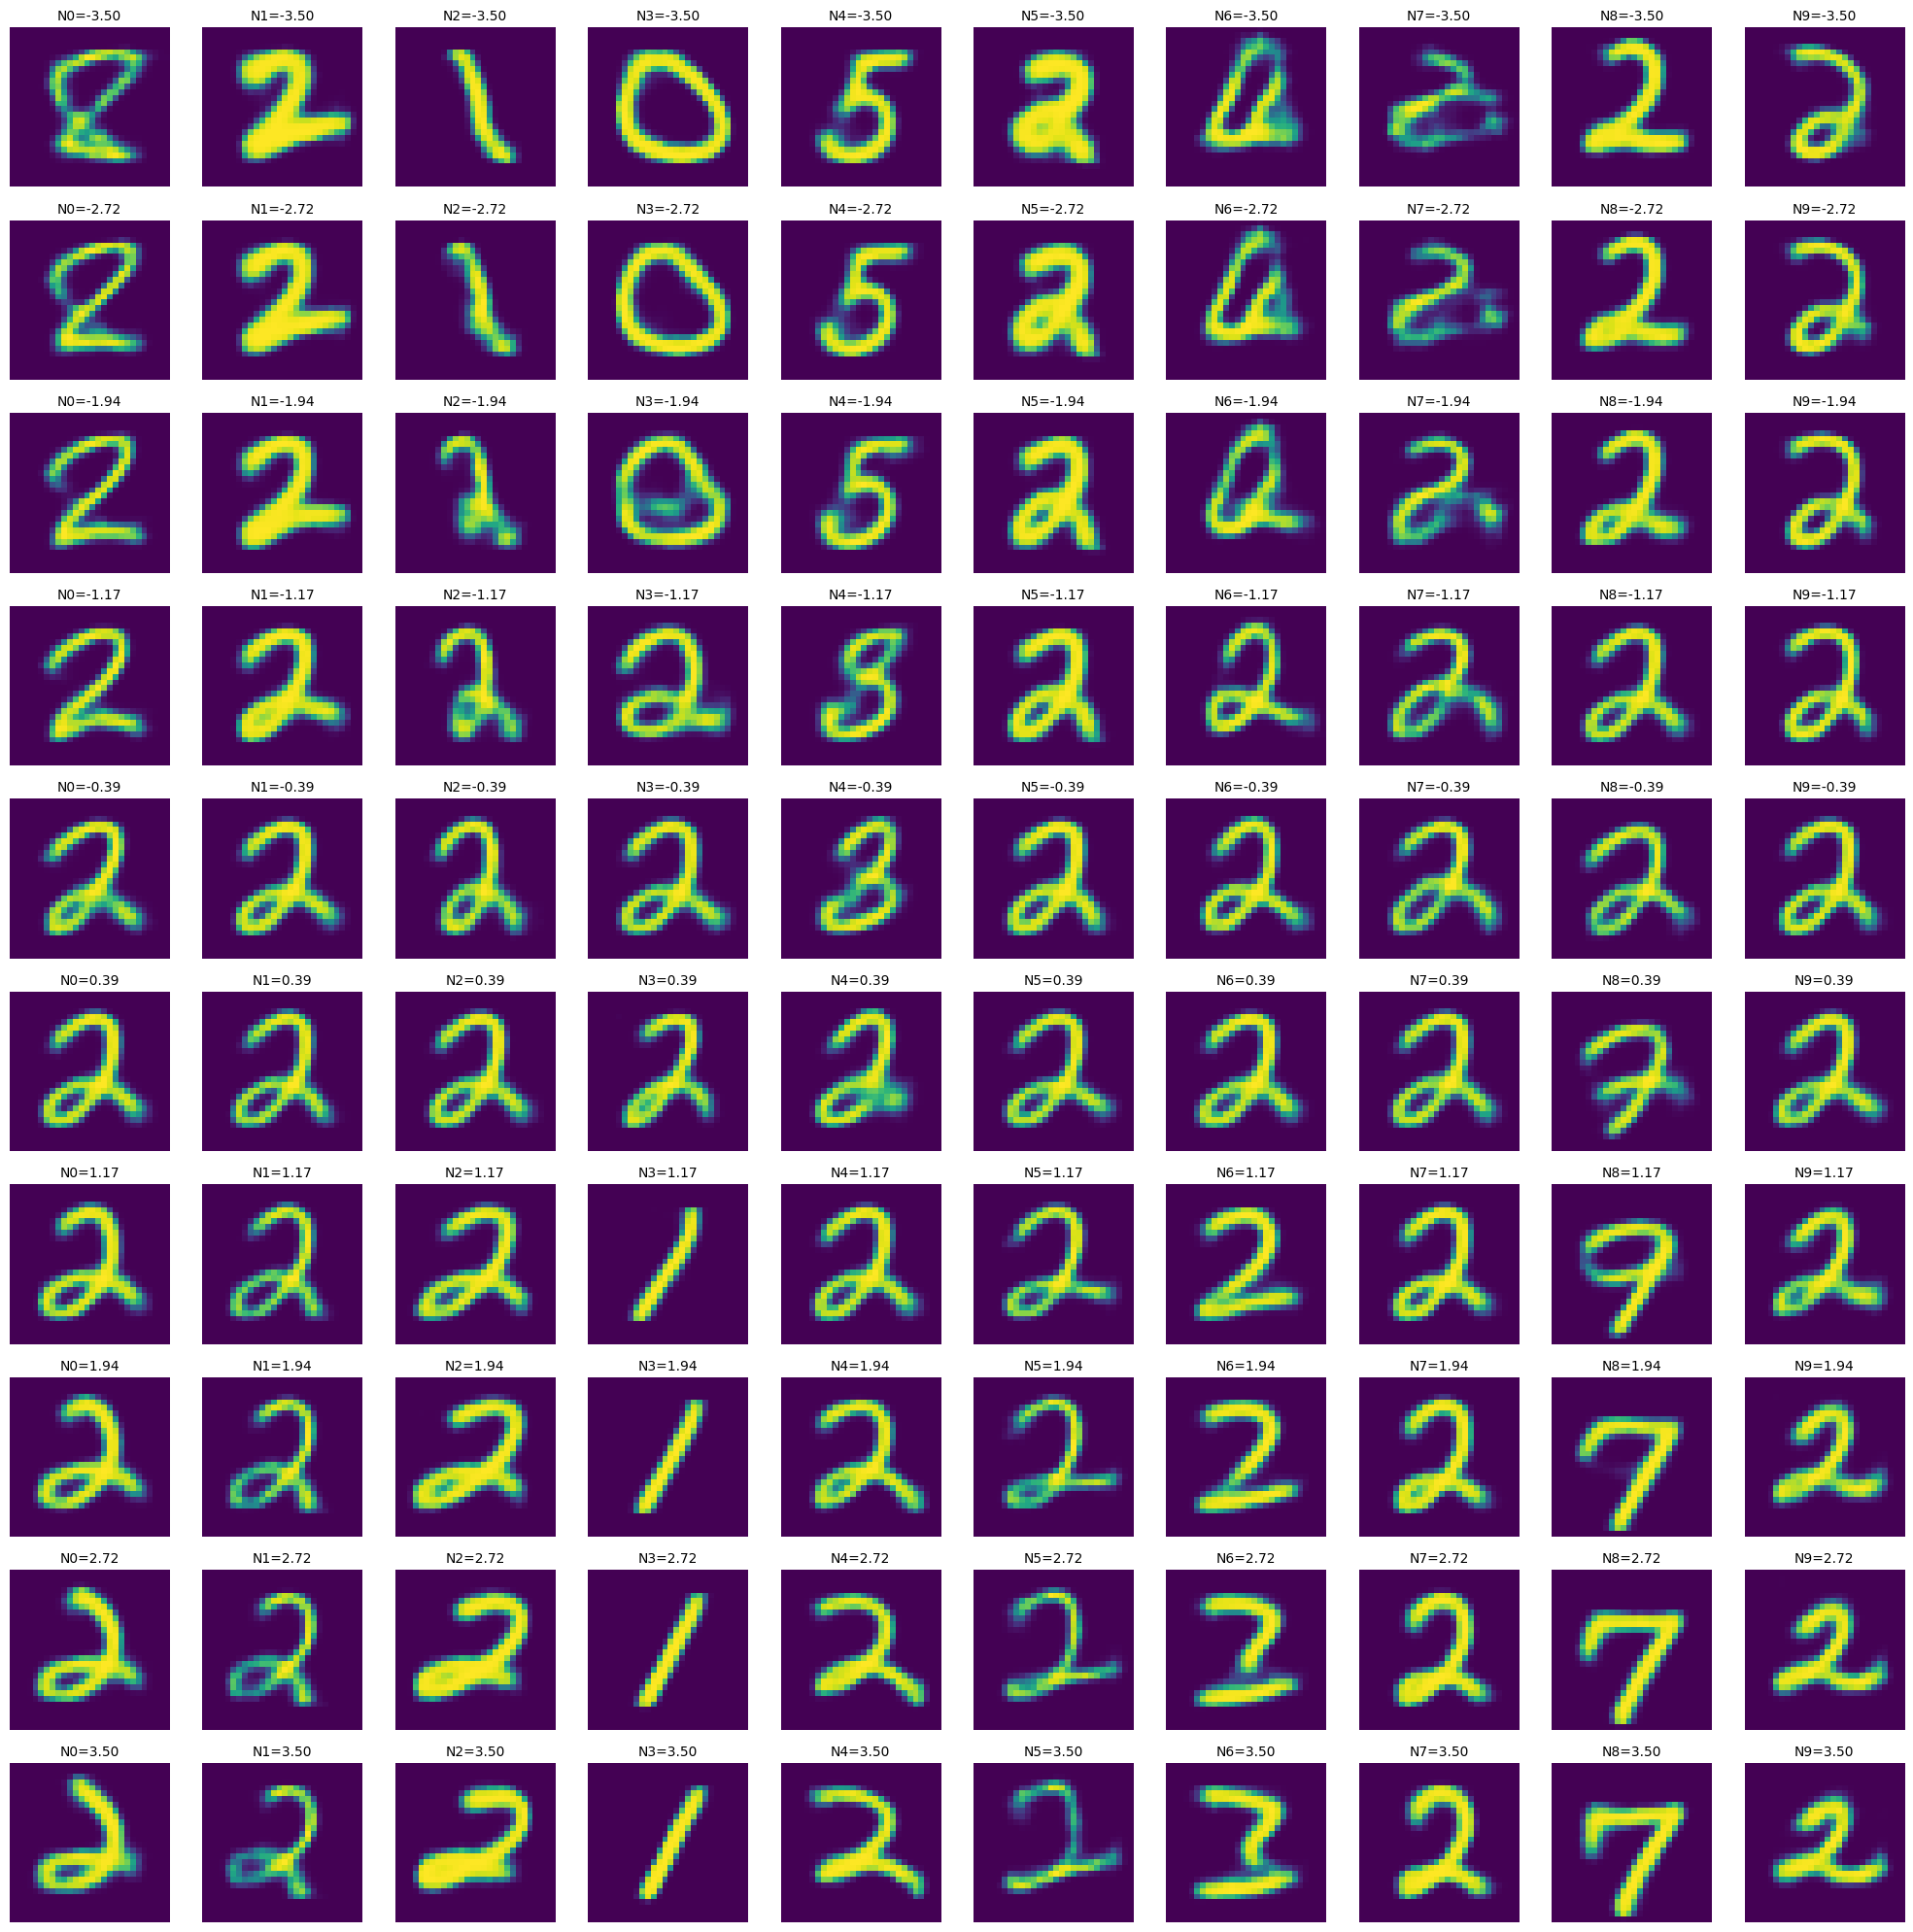

In [11]:
import matplotlib.pyplot as plt
import torch
from torch.distributions import Normal

def generate_images_with_neuron_progression(model, neurons_to_iterate, neuron_values, num_images=16, steps=11, start_value=-2, end_value=2):
    model.eval()
    with torch.no_grad():
        dist = Normal(0, 1)
        
        if neurons_to_iterate is all:
            neurons_to_iterate = list(neuron_values.keys())
        elif not isinstance(neurons_to_iterate, list):
            neurons_to_iterate = [neurons_to_iterate]
        
        num_neurons = len(neurons_to_iterate)
        fig, axes = plt.subplots(steps, num_neurons, figsize=(num_neurons*2, steps*2))
        
        # Ensure axes is always a 2D array
        if num_neurons == 1:
            axes = axes[:, None]
        
        for step in range(steps):
            z = dist.sample((num_images, model.latent_dim)).to(device)
            
            for neuron, value in neuron_values.items():
                z[:, neuron] = value
            
            iterated_value = start_value + (end_value - start_value) * step / (steps - 1)
            
            for col, neuron_to_iterate in enumerate(neurons_to_iterate):
                z_neuron = z.clone()
                z_neuron[:, neuron_to_iterate] = iterated_value
                
                generated_images = model.decode(z_neuron).cpu()
                
                ax = axes[step, col]
                ax.imshow(generated_images[0].squeeze(), cmap='viridis')
                ax.axis('off')
                ax.set_title(f"N{neuron_to_iterate}={iterated_value:.2f}", fontsize=10)
        
        manipulated_info = ", ".join([f"N{n}={v:.2f}" for n, v in neuron_values.items()])
        
        plt.tight_layout()
        plt.show()

# Example usage:
neuron_values = {
    0: 0.298981,
    1: -0.117513,
    2: 0.453713,
    3: -0.172469,
    4: 1.084756,
    5: 0.045994,
    6: 0.228449,
    7: 0.616141,
    8: -1.155827,
    9: -0.067055,
}
neurons_to_iterate = all  # Use 'all' to iterate over all neurons in neuron_values, a single neuron nuber or a list can be used as well
start_value = -3.5  # Start of the range
end_value = 3.5  # End of the range
generate_images_with_neuron_progression(model, neurons_to_iterate, neuron_values, num_images=1, steps=10, start_value=start_value, end_value=end_value)

# Manifold representation of two selected neurons



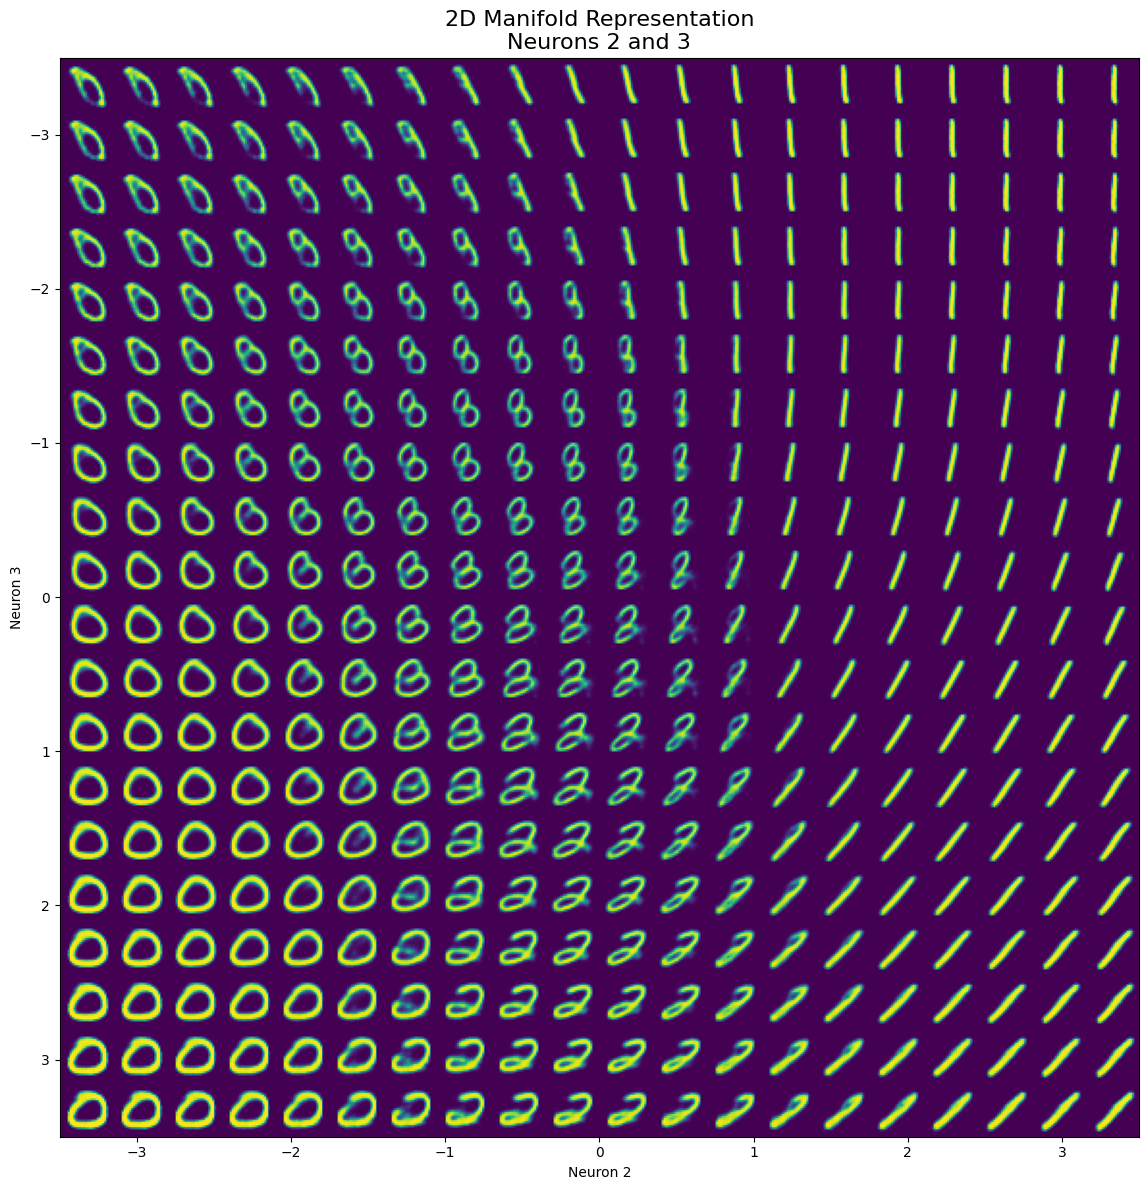

In [12]:
import matplotlib.pyplot as plt
import torch
from torch.distributions import Normal
import numpy as np

def generate_2d_manifold(model, neuron1, neuron2, neuron_values, num_images=16, steps=11, start_value=-2, end_value=2):
    model.eval()
    with torch.no_grad():
        dist = Normal(0, 1)
        
        fig, ax = plt.subplots(figsize=(12, 12))
        
        images = []
        for i, value1 in enumerate(torch.linspace(start_value, end_value, steps)):
            row_images = []
            for j, value2 in enumerate(torch.linspace(start_value, end_value, steps)):
                z = dist.sample((num_images, model.latent_dim)).to(device)
                
                for neuron, value in neuron_values.items():
                    z[:, neuron] = value
                
                z[:, neuron1] = value1
                z[:, neuron2] = value2
                
                generated_image = model.decode(z).cpu()
                row_images.append(generated_image[0].squeeze().numpy())
            
            images.append(row_images)
        
        # Combine all images into a single array
        combined_image = np.concatenate([np.concatenate(row, axis=1) for row in images], axis=0)
        
        # Display the combined image
        im = ax.imshow(combined_image, cmap='viridis', extent=[start_value, end_value, end_value, start_value])
        
        # Set labels and title
        ax.set_xlabel(f'Neuron {neuron1}')
        ax.set_ylabel(f'Neuron {neuron2}')
        ax.set_title(f'2D Manifold Representation\nNeurons {neuron1} and {neuron2}', fontsize=16)
        
        # Remove grid lines
        ax.grid(False)
        
        # Remove color bar (legend)
        # plt.colorbar(im, ax=ax, label='Pixel values')
        
        plt.tight_layout()
        plt.show()

# Example usage:
neuron_values = {
    0: 0.121070,
    1: -0.012976,
    2: -0.825163,
    3: 1.607958,
    4: 0.384948,
    5: 0.006644,
    6: 0.158247,
    7: -0.073463,
    8: -0.591086,
    9: 0.019047,
}

# Select two neurons to visualize
neuron1 = 2  # Change this to your desired neuron
neuron2 = 3  # Change this to your desired neuron

start_value = -3.5
end_value = 3.5

generate_2d_manifold(model, neuron1, neuron2, neuron_values, num_images=1, steps=20, start_value=start_value, end_value=end_value)


# Plot t-SNE, PCA and UMAP

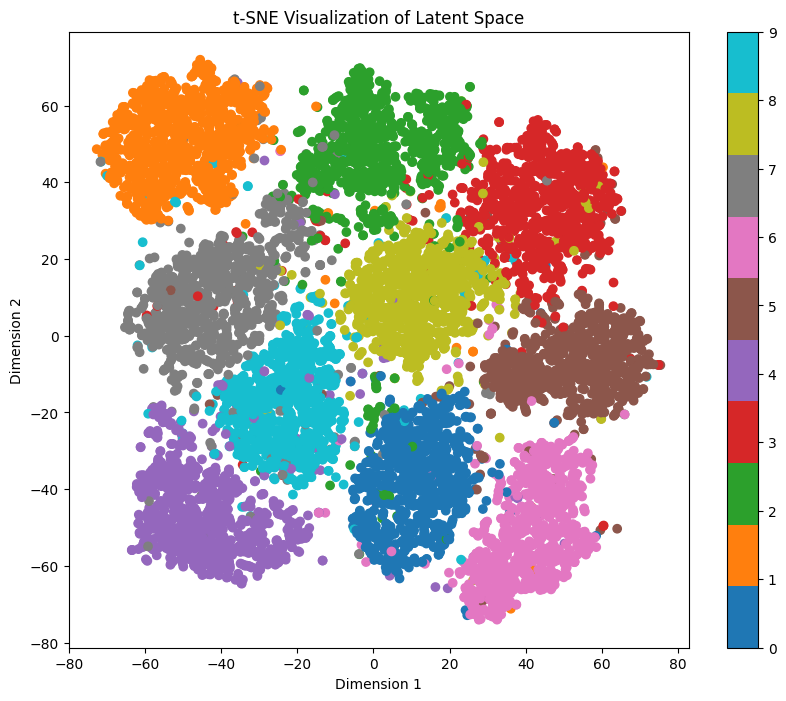

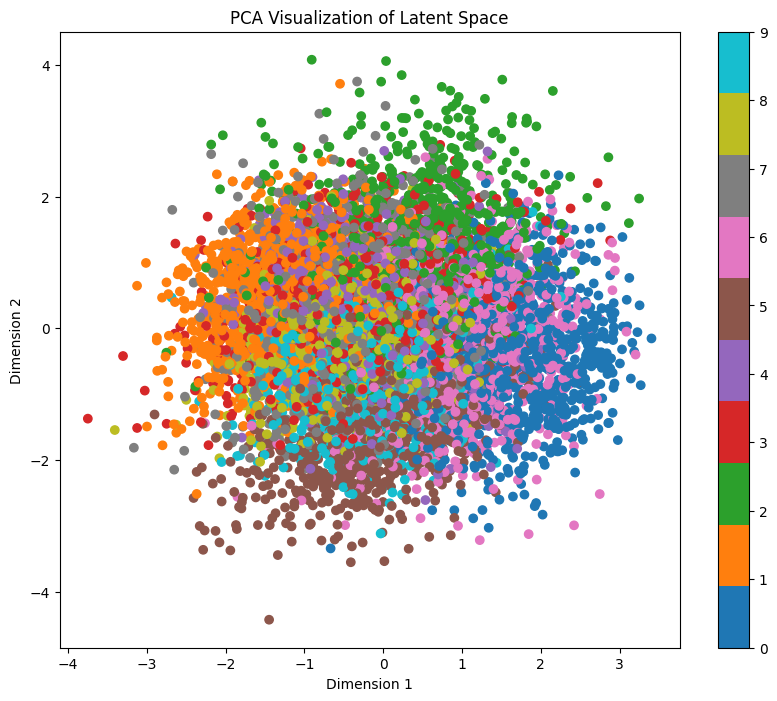

PCA explained variance ratio: [0.12009994 0.11843655]


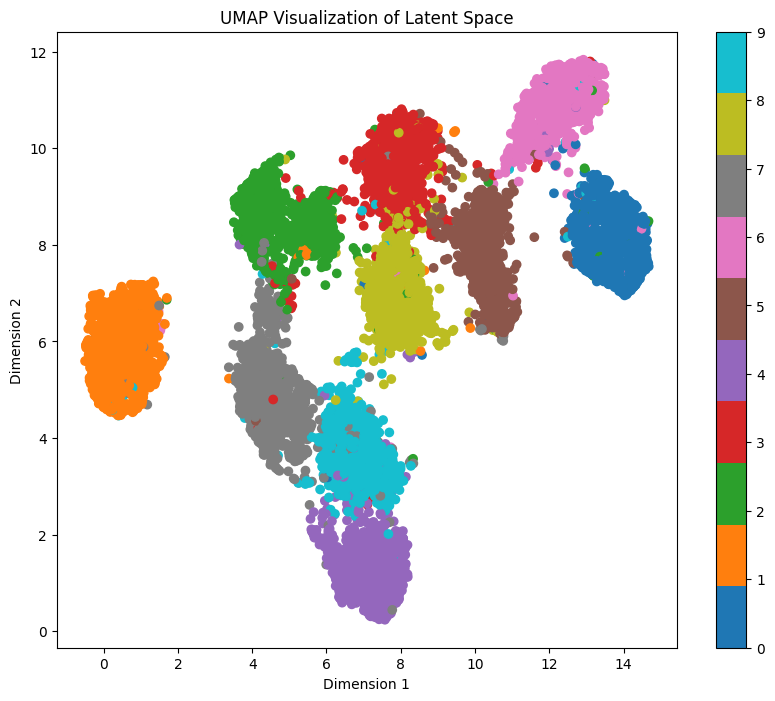

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.preprocessing import StandardScaler

def plot_embedding(X, y, title):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10')
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

def create_visualizations(df):
    # Extract latent representations
    latent_cols = [col for col in df.columns if col.startswith('Activation')]
    X = df[latent_cols].values
    y = df['Digit'].values

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    plot_embedding(X_tsne, y, 't-SNE Visualization of Latent Space')

    # PCA
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    plot_embedding(X_pca, y, 'PCA Visualization of Latent Space')

    # Print explained variance ratio for PCA
    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")

    # UMAP
    umap_model = UMAP(n_components=2, random_state=42, n_jobs=1)
    X_umap = umap_model.fit_transform(X_scaled)
    plot_embedding(X_umap, y, 'UMAP Visualization of Latent Space')



# Assuming df is your DataFrame from the previous step
create_visualizations(df)

# Use Custom points list or custom line coordinates to sample from latent space within t-SNE, PCA and UMAP

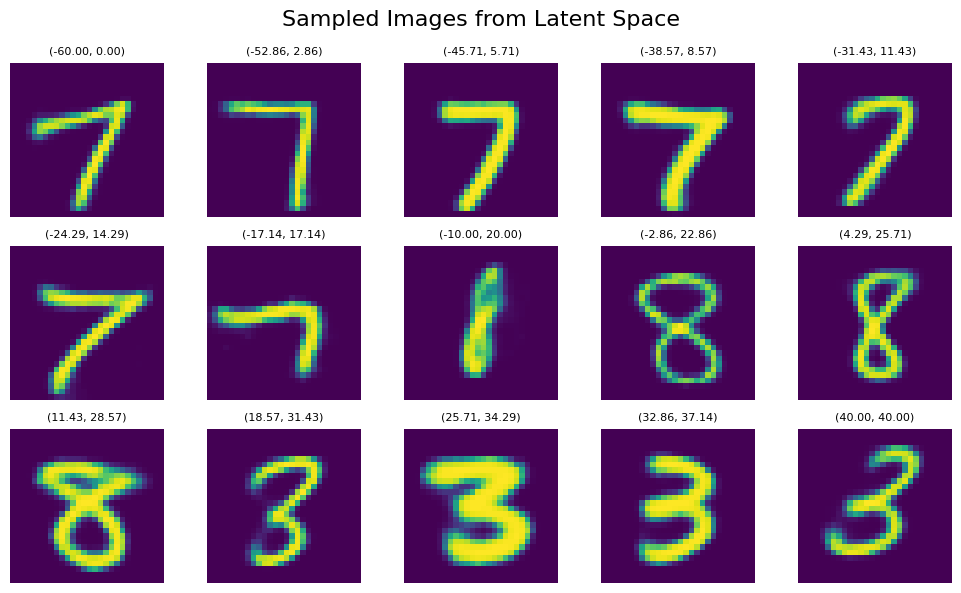

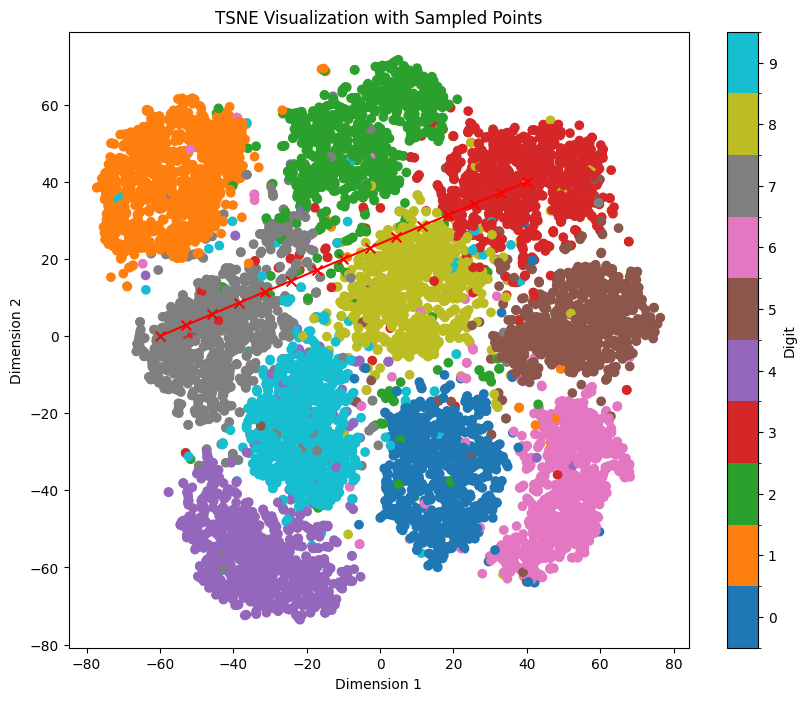

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import matplotlib as mpl
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
import torch

def sample_and_visualize_latent_space(df, model, device, method='umap', sampling_points=None, line_start=None, line_end=None, n_line_samples=10):
    # Extract latent representations
    latent_cols = [col for col in df.columns if col.startswith('Activation')]
    X = df[latent_cols].values
    y = df['Digit'].values

    # Perform dimensionality reduction
    if method == 'umap':
        reducer = UMAP(n_components=2, random_state=42, n_jobs=1)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Method must be one of 'umap', 'tsne', or 'pca'")
    
    X_reduced = reducer.fit_transform(X)

    # Define sampling points
    if sampling_points:
        grid_points = np.array(sampling_points)
    elif line_start and line_end:
        grid_points = np.linspace(np.array(line_start), np.array(line_end), n_line_samples)
    else:
        raise ValueError("Either sampling_points or line_start and line_end must be provided.")

    # Find nearest neighbors in reduced space
    nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
    nn.fit(X_reduced)
    _, indices = nn.kneighbors(grid_points)

    # Get corresponding latent space points
    sampled_latent_points = X[indices.flatten()]

    # Generate images from sampled latent points
    model.eval()
    with torch.no_grad():
        latent_tensor = torch.FloatTensor(sampled_latent_points).to(device)
        generated_images = model.decode(latent_tensor).cpu().numpy()

    # Visualize generated images with coordinates
    n_samples = len(grid_points)
    n_cols = min(5, n_samples)
    n_rows = (n_samples - 1) // n_cols + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows))
    fig.suptitle("Sampled Images from Latent Space", fontsize=16)

    for idx, ax in enumerate(axes.flatten()):
        if idx < n_samples:
            ax.imshow(generated_images[idx].reshape(28, 28), cmap='viridis')
            ax.axis('off')
            coord = grid_points[idx]
            ax.set_title(f"({coord[0]:.2f}, {coord[1]:.2f})", fontsize=8)
        else:
            ax.set_visible(False)

    plt.tight_layout()
    plt.show()

    # Define colors for plotting
    n_classes = len(np.unique(y))
    cmap = mpl.colormaps['tab10']
    norm = BoundaryNorm(np.arange(-0.5, n_classes + 0.5, 1), n_classes)

    # Plot reduced space with sampling points
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap=cmap, norm=norm)
    plt.colorbar(scatter, ticks=np.arange(n_classes), label='Digit')
    plt.scatter(grid_points[:, 0], grid_points[:, 1], c='red', s=50, marker='x')
    
    if line_start and line_end:
        plt.plot([line_start[0], line_end[0]], [line_start[1], line_end[1]], 'r-')
    
    plt.title(f'{method.upper()} Visualization with Sampled Points')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

# Example usage:
# Assuming df is your DataFrame and model is your VAE

# Option 1: Custom points
# custom_points = [
#     [-4, 7], [-2, 7], [0, 7], [2, 7], [4, 7],
#     [-4, 0], [-2, 0], [0, 0], [2, 0], [4, 0],
#     [-4, -7], [-2, -7], [0, -7], [2, -7], [4, -7]
# ]
# sample_and_visualize_latent_space(df, model, device, method='tsne', sampling_points=custom_points)

# Option 2: Line sampling
line_start = [-60, 0]
line_end = [40, 40]
sample_and_visualize_latent_space(df, model, device, method='tsne', line_start=line_start, line_end=line_end, n_line_samples=15)


In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_neuron_activations(model, dataloader, device, num_samples=100, filter_labels=None):
    model.eval()
    activations = []
    filtered_labels = []
    
    with torch.no_grad():
        for data, labels in dataloader:
            if len(activations) >= num_samples:
                break
            
            if filter_labels is not None:
                mask = torch.tensor([label.item() in filter_labels for label in labels])
                if not mask.any():
                    continue
                data = data[mask]
                labels = labels[mask]
            
            data = data.to(device)
            encoded = model.encode(data)
            
            if isinstance(encoded, tuple):
                latent = encoded[0]
            else:
                latent = encoded
            
            activations.append(latent.cpu().numpy())
            filtered_labels.extend(labels.numpy())
    
    activations = np.vstack(activations)[:num_samples]
    filtered_labels = np.array(filtered_labels)[:num_samples]
    
    plt.figure(figsize=(14, 6))
    im = plt.imshow(activations.T, aspect='auto', cmap='viridis')
    plt.colorbar(im, label='Activation')
    plt.title(f'Neuron Activations for Selected Digits')
    plt.xlabel('Sample')
    plt.ylabel('Neuron')
    
    # Add a legend instead of individual labels
    unique_labels = np.unique(filtered_labels)
    legend_elements = [plt.Line2D([0], [0], color='w', marker='o', markersize=10,
                                  markerfacecolor=plt.cm.tab10(i / 10), label=f'Digit {label}')
                       for i, label in enumerate(unique_labels)]
    # plt.legend(handles=legend_elements, title="Digits", loc="center left", bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    plt.show()

def plot_neuron_histograms(model, dataloader, device, num_samples=1000, filter_labels=None):
    model.eval()
    activations = []
    filtered_labels = []
    
    with torch.no_grad():
        for data, labels in dataloader:
            if len(activations) >= num_samples:
                break
            
            if filter_labels is not None:
                mask = torch.tensor([label.item() in filter_labels for label in labels])
                if not mask.any():
                    continue
                data = data[mask]
                labels = labels[mask]
            
            data = data.to(device)
            encoded = model.encode(data)
            
            if isinstance(encoded, tuple):
                latent = encoded[0]
            else:
                latent = encoded
            
            activations.append(latent.cpu().numpy())
            filtered_labels.extend(labels.numpy())
    
    activations = np.vstack(activations)[:num_samples]
    filtered_labels = np.array(filtered_labels)[:num_samples]
    
    num_neurons = activations.shape[1]
    fig, axes = plt.subplots(6, 6, figsize=(20, 20))
    axes = axes.ravel()
    
    for i in range(min(36, num_neurons)):
        axes[i].hist(activations[:, i], bins=50)
        axes[i].set_title(f'Neuron {i}')
    
    plt.suptitle(f'Neuron Activation Histograms for Digits: {filter_labels if filter_labels else "All"}')
    plt.tight_layout()
    plt.show()

# Plot Neuron activation heatmap and neuron activation histograms

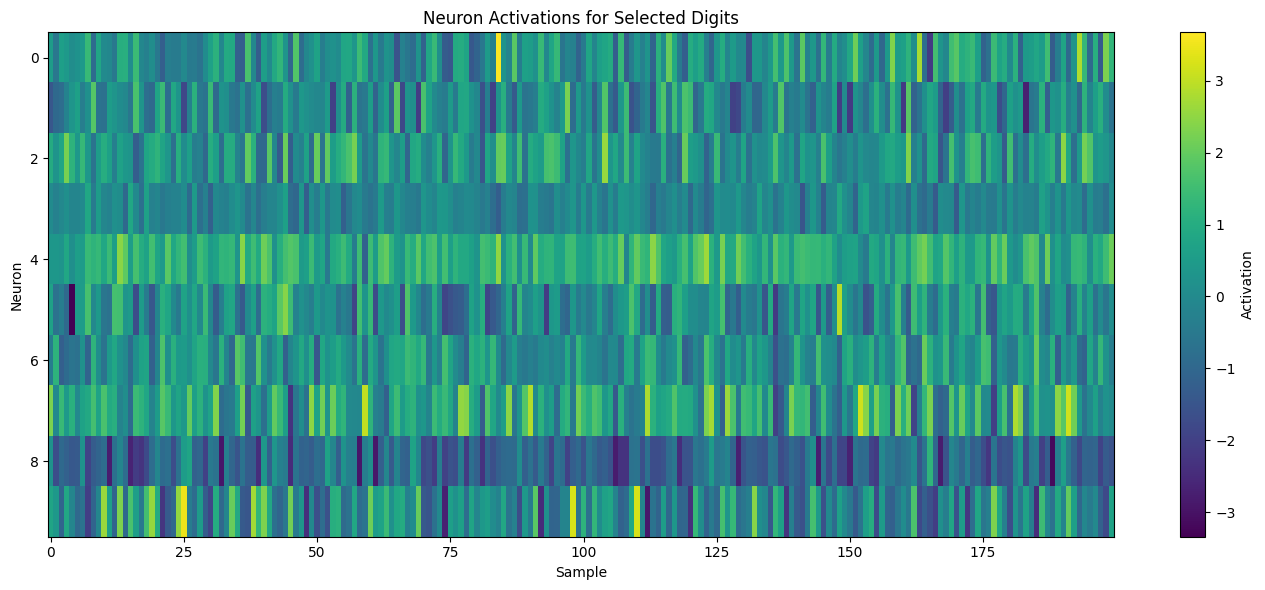

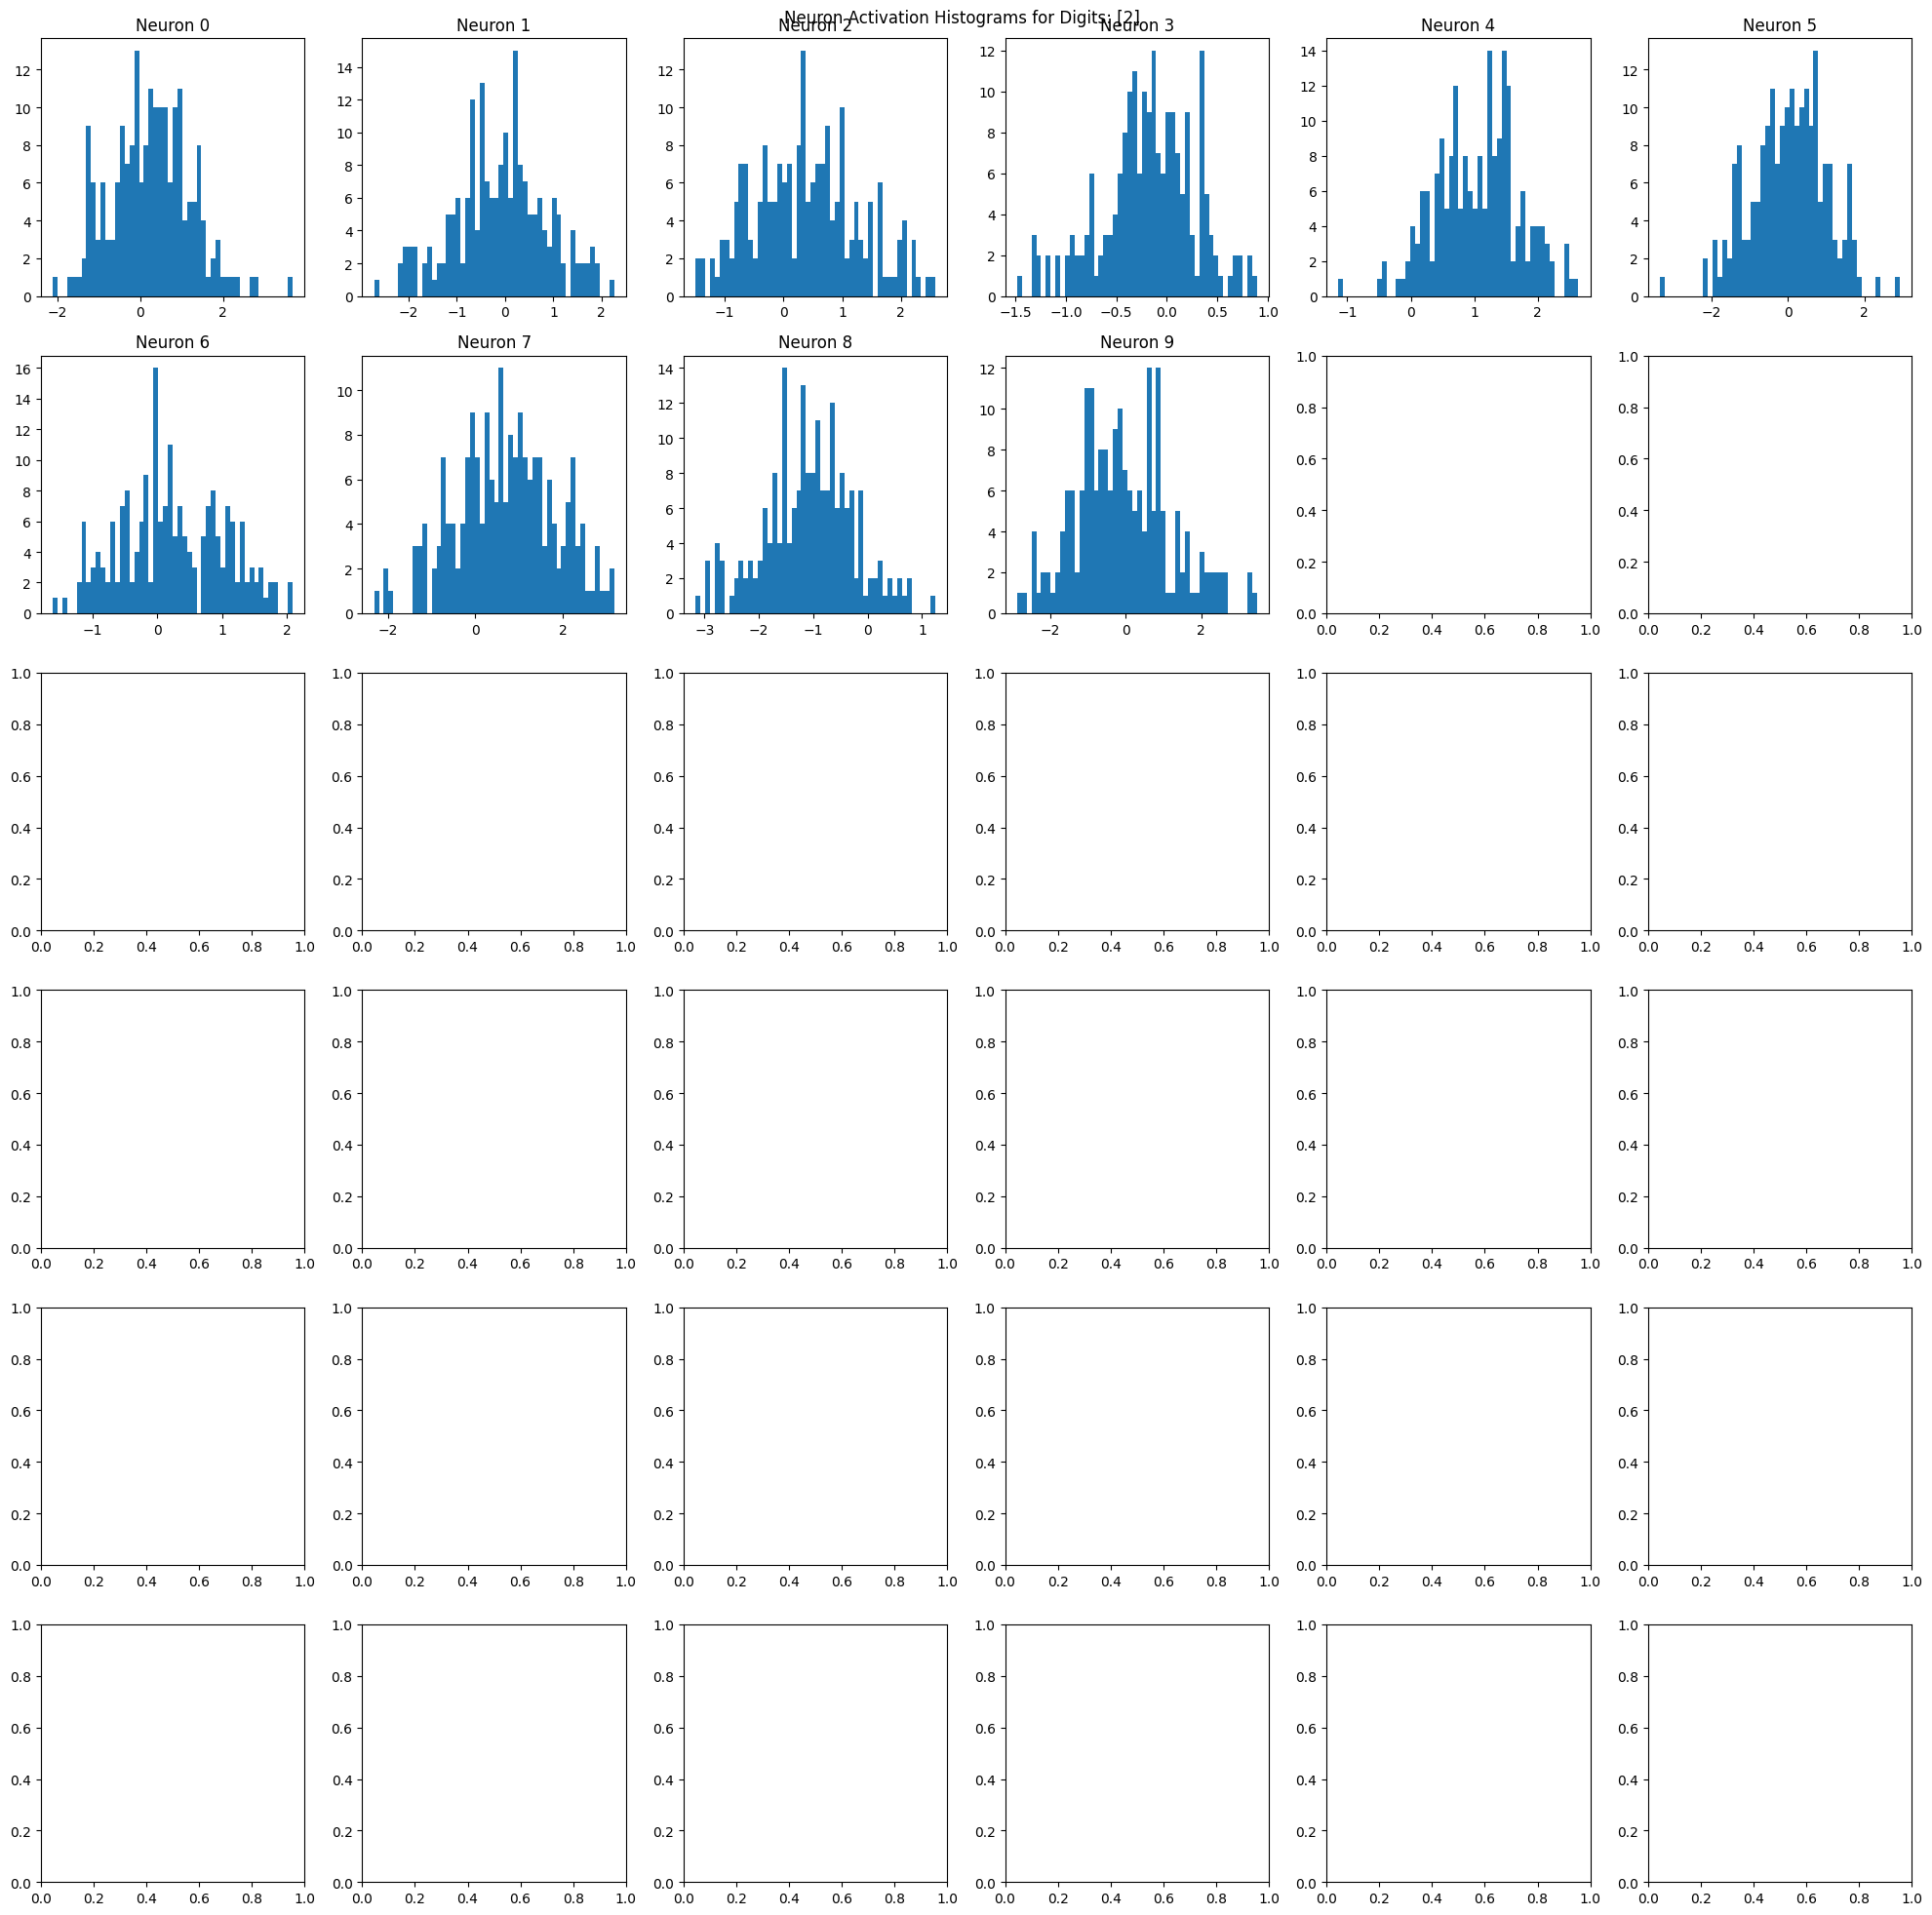

In [17]:
# Neuron activation heatmap 
plot_neuron_activations(model, test_loader, device, num_samples=200, filter_labels=[2])

# Neuron activation histograms
plot_neuron_histograms(model, test_loader, device, num_samples=200, filter_labels=[2])

# To see all digits, simply omit the filter_labels parameter or set it to None
# plot_neuron_activations(model, test_loader, device, num_samples=100)
# plot_neuron_histograms(model, test_loader, device, num_samples=1000)

# Save the current model

In [4]:
import torch

# Save the model weights
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Example usage after training
model_path = 'vae_model_gauss_enh20.pth'
save_model(model, model_path)


# Load a model

Make sure you run and setup the cell with the corresponding model first or you'll get errors.

In [4]:
import torch

# Load the model weights
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()  # Set the model to evaluation mode

# Example usage before inference or further training
model_path = 'vae_model_gauss_enh10.pth'
load_model(model, model_path)
